In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa.core as lc
import librosa
import librosa.display
import IPython.display as ipd

import dataset_loader.music_loader_stft

In [2]:
snippet_size = 512 * (128)
print(snippet_size)
loader = dataset_loader.music_loader_stft.MusicLoaderSTFT('data/fma_xs', split='test', snippet_size=snippet_size)

65536


/home/patrick/miniconda3/envs/cv/lib/python3.7/site-packages/librosa/filters.py:222: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


input_data shape (2, 257, 513)
(257, 513) 42.231285 0.0001304367 2.5201998
(257, 513) 50.164043 5.6228337e-06 2.527186
0.0001304367 2.5201998


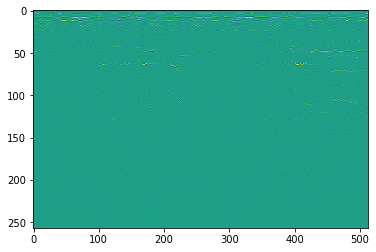

In [3]:
i = np.random.randint(len(loader))
sampling_rate = 8000

input_data, label = loader[i]
input_signal = loader.spec_to_audio(input_data)

real = input_data[0, :, :]
imag = input_data[1, :, :]
print('input_data shape', input_data.shape)
abs_spect = np.linalg.norm(input_data, axis=0)
print(real.shape, real.max(), real.mean(), real.std())
print(imag.shape, imag.max(), imag.mean(), imag.std())

plt.imshow(real, aspect='auto')

print(np.mean(real), np.std(real))

In [4]:
# Original audio

#signal = loader.get_raw(i)
#ipd.Audio(signal, rate=sampling_rate)

In [5]:
# Reconstructed from STFT, with phase information from original data

#reconstruct = loader.spec_to_audio(a, i)
#ipd.Audio(reconstruct, rate=sampling_rate)

In [6]:
n_fft = 512
mel = librosa.feature.melspectrogram(input_signal, sampling_rate, n_fft=n_fft)

ipd.Audio(input_signal, rate=sampling_rate)

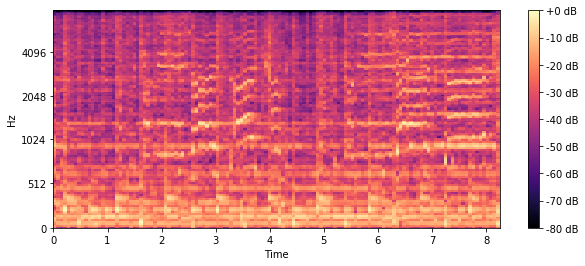

In [7]:
S_dB = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000)
plt.colorbar(format='%+2.0f dB')

ft shape (257, 513)
mel bank shape (512, 257) 512
Mel spectrogram


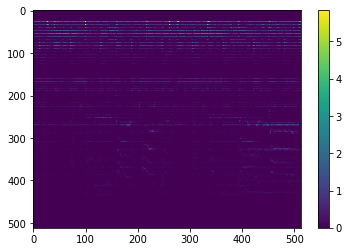

In [8]:
n_fft = 512
ft = lc.stft(input_signal, n_fft=n_fft)
print('ft shape', ft.shape)
mel_bank = librosa.filters.mel(sampling_rate*3, n_fft=n_fft, n_mels=512)
print('mel bank shape', mel_bank.shape, n_fft)
real = np.real(ft)
imag = np.imag(ft)

mel_fft_r = mel_bank.dot(real)
mel_fft_i = mel_bank.dot(imag)

inv_mel_mat = np.linalg.pinv(mel_bank)
inv_mel_r = inv_mel_mat.dot(mel_fft_r)
inv_mel_i = inv_mel_mat.dot(mel_fft_i)
inv_mel = inv_mel_r + 1j * inv_mel_i
inv_mel_sig = lc.istft(inv_mel)

print("Mel spectrogram")

plt.imshow(abs(mel_fft_r + 1j* mel_fft_i), aspect='auto')
plt.colorbar()

STFT -> mel -> STFT


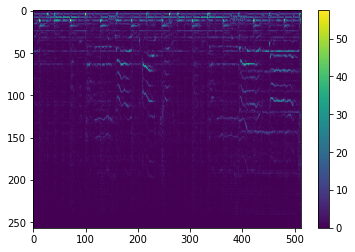

In [9]:
print("STFT -> mel -> STFT")

plt.imshow(abs(inv_mel_r + 1j* inv_mel_i), aspect='auto')
plt.colorbar()

ipd.Audio(inv_mel_sig, rate=sampling_rate)

Original STFT


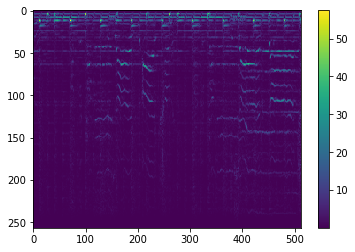

In [10]:
print('Original STFT')

plt.imshow(abs(real + 1j* imag), aspect='auto')
plt.colorbar()

In [11]:
y = librosa.feature.inverse.mel_to_audio(mel, sampling_rate, n_fft=1024)

ipd.Audio(y, rate=sampling_rate)

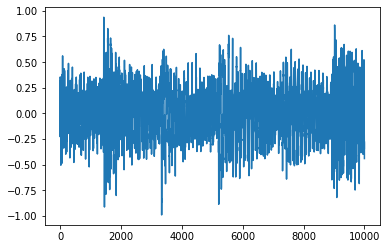

In [12]:
# Plot original vs reconstructed

#plt.plot(signal[:10000])
plt.plot(input_signal[:10000])

Input shape torch.Size([1, 2, 257, 513]) size 263682
Latent shape torch.Size([1, 8, 62, 126]) size 62496
Output shape torch.Size([1, 2, 257, 513]) size 263682
0.6352391242980957
input mean, std 6.8029825e-05 2.5236952
output mean, std -0.0012560597 2.3843584


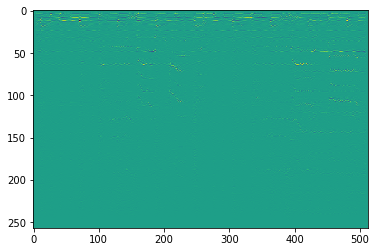

In [13]:
import os
import torch.utils
from torch.autograd import Variable
from models.frequency_autoencoder import FrequencyAutoencoder
from dataset_loader.music_loader_stft import MusicLoaderSTFT

model_dir = 'model_logs/'

model = FrequencyAutoencoder()
model.cuda()

checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

input_tensor = torch.from_numpy(np.expand_dims(input_data, axis=0))

input_tensor = Variable(input_tensor).cuda()
output_tensor, _ = model.forward(input_tensor)
loss = float(model.loss_criterion(input_tensor, output_tensor))

print(loss)

output = output_tensor.cpu().data.numpy()
output = output.squeeze()

plt.imshow(output[0, :, :], aspect='auto')

print("input mean, std", input_data.mean(), input_data.std())
print("output mean, std", output.mean(), output.std())

In [14]:
# Original audio

ipd.Audio(input_signal, rate=sampling_rate)

In [15]:
# Autoencoded compressed

reconstruct_no_phase = loader.spec_to_audio(output)
ipd.Audio(reconstruct_no_phase, rate=sampling_rate)

In [16]:
# Resampled to roughly 2kbps

resampled = lc.resample(input_signal, 8000, 2000)
ipd.Audio(resampled, rate=2000)

In [17]:
import soundfile

for i in range(10):
    rand_idx = np.random.randint(len(loader))
    input_data, label = loader[rand_idx]
    input_tensor = torch.from_numpy(np.expand_dims(input_data, axis=0))

    input_tensor = Variable(input_tensor).cuda()
    output_tensor, _ = model.forward(input_tensor)
    output = output_tensor.cpu().data.numpy()
    output = output.squeeze()
    
    
    input_signal = loader.spec_to_audio(input_data)
    reconstruct = loader.spec_to_audio(output)
    
    to_save = np.concatenate((input_signal, reconstruct))
    file_name = str(i) + '.wav'
    
    
    soundfile.write(file_name, to_save, sampling_rate)